In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
import re
%matplotlib inline

In [2]:
%%time
df_original = pd.read_csv('vehicles.csv')

CPU times: user 11.9 s, sys: 4.89 s, total: 16.8 s
Wall time: 24.6 s


# Speculate the dataset

In [3]:
df_original.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


In [4]:
# choose features whose unique values < 100, i.e. drop features like url and id
features = [i for i in df_original.columns if len(df_original[i].unique()) < 100]
# add feature 'price' back (don't wanna lose our target value!)
features.append('price')
df = df_original[features]
df.head()

,manufacturer,condition,cylinders,fuel,title_status,transmission,drive,size,type,paint_color,county,state,price
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,6000
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar,11900
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl,21000
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma,1500
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc,4900


In [5]:
print('number of rows before filtering: ', len(df))
print('precent of NaN values in all columns:\n', df.isnull().sum()/len(df))
for i in list(df.columns):
    print('The number of unique values in Column {} is {}'.format(i, str(len(df[i].unique()))))

number of rows before filtering:  426880
precent of NaN values in all columns:
 manufacturer    0.041337
condition       0.407852
cylinders       0.416225
fuel            0.007058
title_status    0.019308
transmission    0.005988
drive           0.305863
size            0.717675
type            0.217527
paint_color     0.305011
county          1.000000
state           0.000000
price           0.000000
dtype: float64
The number of unique values in Column manufacturer is 43
The number of unique values in Column condition is 7
The number of unique values in Column cylinders is 9
The number of unique values in Column fuel is 6
The number of unique values in Column title_status is 7
The number of unique values in Column transmission is 4
The number of unique values in Column drive is 4
The number of unique values in Column size is 5
The number of unique values in Column type is 14
The number of unique values in Column paint_color is 13
The number of unique values in Column county is 1
The n

In [ ]:
from skfeature.function.similarity_based import fisher_score
X = df.drop(columns = 'price')
y = df['price']
score = fisher_score.fisher_score(X.to_numpy(), y.to_numpy())

### For some features like 'cylinders', a large number of data is missing according to the data above. Therefore, some interesting features are selected based on common sense.

In [7]:
# choose the interesting features
df = df_original[['id', 'price', 'year', 'manufacturer', 'fuel', 
                  'odometer', 'title_status', 'type', 'state', 'posting_date']]
print('number of rows before dropna: ', len(df))
print('precent of NaN values in all columns:\n', df.isnull().sum()/len(df))
print('The number of unique values in all columns:\n', df.nunique())

number of rows before dropna:  426880
precent of NaN values in all columns:
 id              0.000000
price           0.000000
year            0.002823
manufacturer    0.041337
fuel            0.007058
odometer        0.010307
title_status    0.019308
type            0.217527
state           0.000000
posting_date    0.000159
dtype: float64
The number of unique values in all columns:
 id              426880
price            15655
year               114
manufacturer        42
fuel                 5
odometer        104870
title_status         6
type                13
state               51
posting_date    381536
dtype: int64


In [8]:
df.head()

,id,price,year,manufacturer,fuel,odometer,title_status,type,state,posting_date
0,7222695916,6000,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN
1,7218891961,11900,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN
2,7221797935,21000,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN
3,7222270760,1500,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN
4,7210384030,4900,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN


In [9]:
df.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


id           -1.430123
price       254.406932
year         -3.577920
odometer     38.040015
dtype: float64


/Users/junqingzhu/opt/anaconda3/envs/combustion/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/junqingzhu/opt/anaconda3/envs/combustion/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/junqingzhu/opt/anaconda3/envs/combustion/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f972c75fed0>,
      dtype=object)

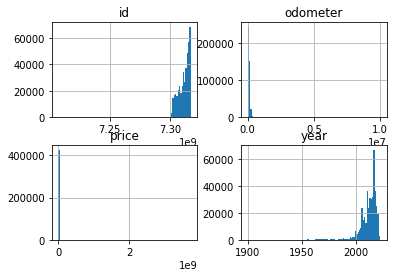

In [10]:
print(df.skew())
df.hist(bins = 100)

### Data price and odometer is highly skewed. Since price is the target value, data cleaning is needed before model training.

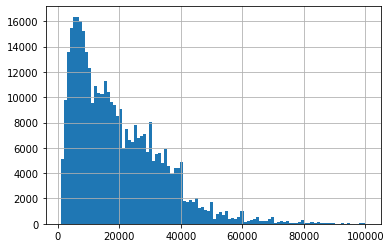

In [11]:
df[df['price'].gt(1000) & df['price'].lt(100000)]['price'].hist(bins = 100)

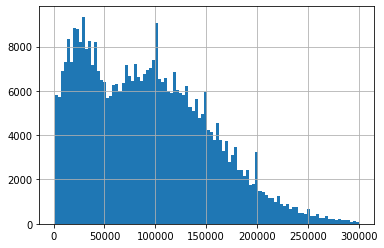

In [12]:
df[df['odometer'].gt(1000) & df['odometer'].lt(300000)]['odometer'].hist(bins = 100)

# Drop rows with NaN and filter 1000 < price < 100000 (for practical purpose)

In [13]:
df = df[df['price'].gt(1000) & df['price'].lt(100000)]
df.dropna(inplace = True)
df.reset_index(drop = True, inplace = True)
print('number of rows after these filtering: ', len(df))
print('precent of NaN values in all columns:\n', df.isnull().sum()/len(df))
print('The number of unique values in columns:\n', df.nunique())
# df.to_csv('Kaggle used car cleaned.csv', index=False)

number of rows after these filtering:  279572
precent of NaN values in all columns:
 id              0.0
price           0.0
year            0.0
manufacturer    0.0
fuel            0.0
odometer        0.0
title_status    0.0
type            0.0
state           0.0
posting_date    0.0
dtype: float64
The number of unique values in columns:
 id              279572
price            12053
year               104
manufacturer        42
fuel                 5
odometer         79438
title_status         6
type                13
state               51
posting_date    250344
dtype: int64


# Other filtering and Categorical Encoding

According to the Tableau visualization (https://public.tableau.com/app/profile/junqing.zhu/viz/Kaggleusedcarvisualization/HowOdometerYearandStateaffectPrice):

Year and Median Odometer are related and both correlate well with Median Price
Type, Manufacturer, and Fuel make the Median Price - Median Odometer curve more dispersed
State doesn't make the Median Price - Median Odometer curve more dispersed
Title Status needs to be filtered.


In [14]:
df = df[df['title_status'] == 'clean']
df = df[['price', 'manufacturer', 'fuel', 'odometer', 'type', 'state', 'year']]
df.reset_index(inplace = True, drop = True)
df.head()

,price,manufacturer,fuel,odometer,type,state,year
0,33590,gmc,gas,57923.0,pickup,al,2014.0
1,22590,chevrolet,gas,71229.0,pickup,al,2010.0
2,39590,chevrolet,gas,19160.0,pickup,al,2020.0
3,30990,toyota,gas,41124.0,pickup,al,2017.0
4,15000,ford,gas,128000.0,truck,al,2013.0


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

In [16]:
y = df['price']
X = df.drop(columns = ['price'])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [17]:
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)
print(object_cols)
df['manufacturer'].unique()

['manufacturer', 'fuel', 'type', 'state']


array(['gmc', 'chevrolet', 'toyota', 'ford', 'jeep', 'nissan', 'ram',
       'mazda', 'cadillac', 'honda', 'lexus', 'jaguar', 'buick',
       'chrysler', 'volvo', 'audi', 'infiniti', 'lincoln', 'alfa-romeo',
       'subaru', 'acura', 'hyundai', 'mercedes-benz', 'bmw', 'mitsubishi',
       'volkswagen', 'porsche', 'kia', 'rover', 'ferrari', 'pontiac',
       'dodge', 'fiat', 'tesla', 'mini', 'saturn', 'mercury',
       'harley-davidson', 'datsun', 'aston-martin', 'land rover',
       'morgan'], dtype=object)

In [18]:
label_X_train = X_train.copy()
label_X_test = X_test.copy()
ordinal_encoder = OrdinalEncoder()
label_X_train[object_cols] = ordinal_encoder.fit_transform(X_train[object_cols])
label_X_test[object_cols] = ordinal_encoder.fit_transform(X_test[object_cols])

# Speculate the Spearman's correlation matrix

In [19]:
label_all = df.copy()
label_all[object_cols] = ordinal_encoder.fit_transform(df[object_cols])
label_all.head()

,price,manufacturer,fuel,odometer,type,state,year
0,33590,14.0,2.0,57923.0,8.0,1.0,2014.0
1,22590,7.0,2.0,71229.0,8.0,1.0,2010.0
2,39590,7.0,2.0,19160.0,8.0,1.0,2020.0
3,30990,39.0,2.0,41124.0,8.0,1.0,2017.0
4,15000,13.0,2.0,128000.0,10.0,1.0,2013.0


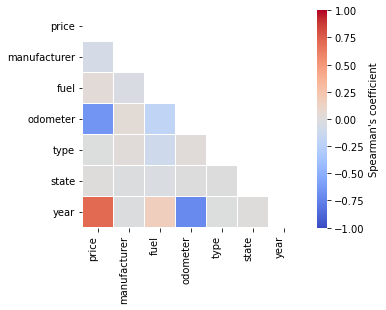

In [20]:
corr = label_all.corr(method = 'spearman')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(
    corr, mask=mask, linewidths=.1,
    vmin=-1, vmax=1, center=0, cmap = 'coolwarm',
    square=True, cbar_kws={'label': 'Spearman\'s coefficient'}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);
plt.show()

# Define a plot function for result visualization

In [21]:
def plot_target_and_prediction(reg, X_test, y_test):
    y_test_pred = reg.predict(X_test)
    plt.scatter(y_test, y_test_pred, marker= 'o')
    plt.plot(y_test, y_test, 'r-')
    plt.title('R2 ={}'.format(reg.score(X_test, y_test)))
    plt.xlabel('Target price (y)')
    plt.ylabel('Predicted price (y_pred)')
    plt.tight_layout()
    plt.show()

# Define a model fit function for fitting and result visualization

In [50]:
def model_fit(reg, X_train, y_train, X_test, y_test, cv = False):
    from sklearn.metrics import mean_absolute_error, r2_score
    reg.fit(X_train,y_train)
    print ('\nModel Report')
    print('R^2 of the training set:', round(r2_score(reg.predict(X_train), y_train), 4))
    print('R^2 of the testing set:', round(r2_score(reg.predict(X_test), y_test), 4))
    print('MAE of the training set:', round(mean_absolute_error(reg.predict(X_train), y_train), 4))
    print('MAE of the testing set:', round(mean_absolute_error(reg.predict(X_test), y_test), 4))
    if cv:
        from sklearn.model_selection import cross_val_score
        scores = cross_val_score(reg, X_train, y_train, cv = cv, scoring='r2')
        print('The average R^2 of the {}-fold cross validation = {}, with a std of {}'
              .format(cv, round(scores.mean(), 4), round(scores.std(), 4)))
    plot_target_and_prediction(reg, X_train, y_train)
    plot_target_and_prediction(reg, X_test, y_test)
#     reg.plot_importance(reg)

# Try different regressor

## 1. Linear Regression

In [23]:
from sklearn.linear_model import LinearRegression
linreg= LinearRegression().fit(label_X_train, y_train)
print(label_X_train.head())
print(y_train.head())

        manufacturer  fuel  odometer  type  state    year
222020          16.0   2.0  116699.0   0.0   41.0  2012.0
242100          13.0   2.0  101802.0   7.0   43.0  2014.0
120461          14.0   2.0  114541.0   0.0   19.0  2013.0
142730           7.0   2.0  157192.0  10.0   26.0  2013.0
105186           4.0   2.0  141000.0   0.0   12.0  2008.0
222020    15397
242100    11995
120461    22997
142730    24995
105186     5999
Name: price, dtype: int64


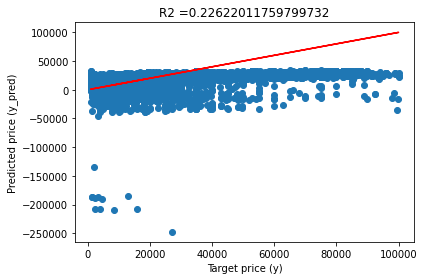

In [24]:
plot_target_and_prediction(linreg, label_X_test, y_test)

## 2. XGBoost

In [25]:
import xgboost as xgb
# initialize the regressor, use n_estimators = 1000 (early_stopping rounds = 20 in the upcoming GridSearch)
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators = 1000, verbosity = 0)

### define a function to find the optimal hyperparameters with GridSearch

In [26]:
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import mean_absolute_error, make_scorer

In [27]:
def general_gridsearch(xg_reg, param_test, early_stopping_rounds = 50, eval_metric = 'mae'):
    fit_params={'early_stopping_rounds': early_stopping_rounds, 
                'eval_metric' : eval_metric, 
                'eval_set' : [(label_X_train, y_train), (label_X_test, y_test)]}
    gsearch = GridSearchCV(estimator = xg_reg, param_grid = param_test, 
                           scoring = make_scorer(mean_absolute_error), cv=3)
    gsearch.fit(label_X_train, y_train, **fit_params, verbose = False)
    print('The best params are:', gsearch.best_params_,
          'The best mae is:', gsearch.best_score_)
# plot Training Loss and Validation Loss of the best estimator
    results = gsearch.best_estimator_.evals_result()
    plt.figure(figsize=(10,7))
    plt.plot(results["validation_0"]["mae"], label = "Training Loss")
    plt.plot(results["validation_1"]["mae"], label = "Validation Loss")
    plt.xlabel("Number of trees")
    plt.ylabel("MAE")
    plt.legend()
    return gsearch.best_estimator_

### Use grid search to find the optimal values for different hyperparameters

The best params are: {'min_child_weight': 30} The best mae is: 4638.236946909888
CPU times: user 3min 54s, sys: 4.4 s, total: 3min 58s
Wall time: 32.9 s


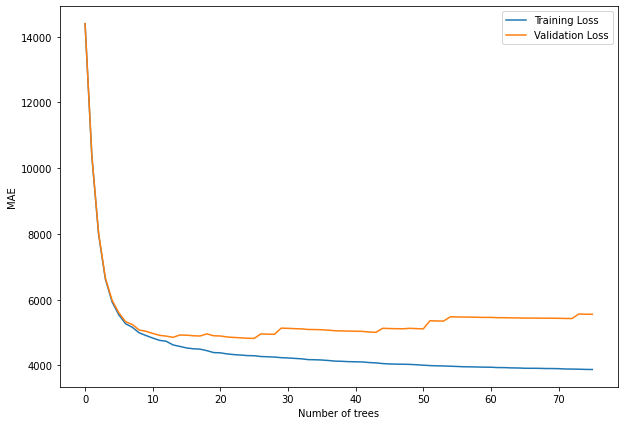

In [28]:
%%time
param_test = {
 'min_child_weight':range(6,31,12)
}
updated_xg_reg = general_gridsearch(xg_reg = xg_reg, param_test = param_test)


Model Report
R2 of the training set: 0.721
R2 of the testing set: 0.6862
MAE of the training set: 4295.4028
MAE of the testing set: 4823.0069
R2 of the 3-fold cross validation: [0.8573898  0.85410748 0.8549836 ]


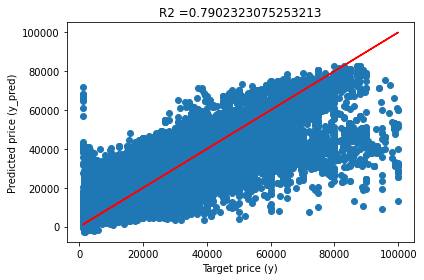

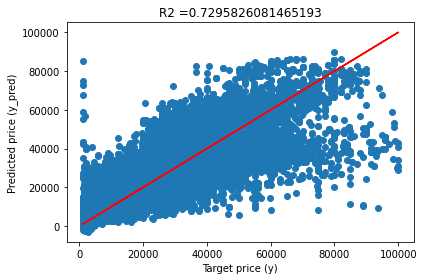

In [29]:
model_fit(updated_xg_reg, label_X_train, y_train, label_X_test, y_test, cv = 3)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=30, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=0)
The best params are: {'min_child_weight': 30} The best mae is: 4638.236946909888
CPU times: user 3min 56s, sys: 2.93 s, total: 3min 59s
Wall time: 31.3 s


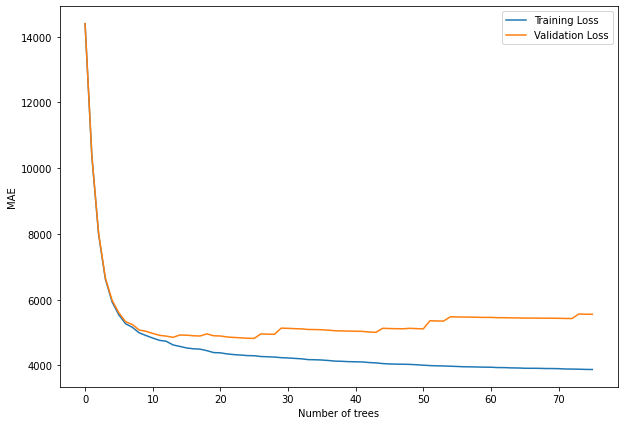

In [30]:
%%time
print(updated_xg_reg)
param_test = {
 'min_child_weight':range(30,43,6)
}
updated_xg_reg = general_gridsearch(xg_reg = xg_reg, param_test = param_test)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=30, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=0)
The best params are: {'gamma': 0, 'max_depth': 3} The best mae is: 4784.487267095891
CPU times: user 17min 9s, sys: 14.6 s, total: 17min 23s
Wall time: 2min 17s


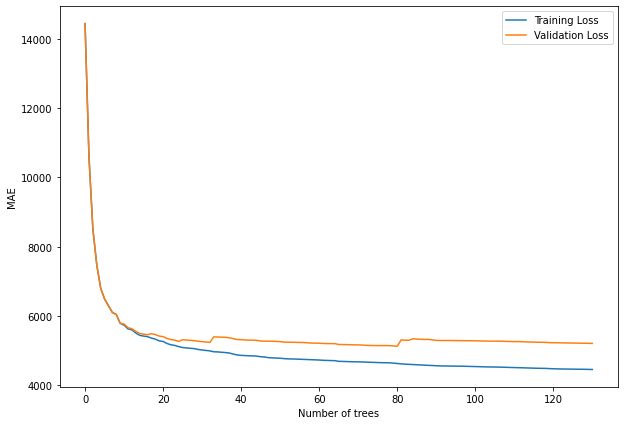

In [31]:
%%time
print(updated_xg_reg)
param_test = {
  'max_depth':range(3,12,4), 'gamma': [0, 0.5, 1, 10]
}
updated_xg_reg = general_gridsearch(xg_reg = updated_xg_reg, param_test = param_test)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=30, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=0)
The best params are: {'reg_lambda': 10.0} The best mae is: 4810.067200057225
CPU times: user 4min 18s, sys: 5.95 s, total: 4min 24s
Wall time: 36.1 s


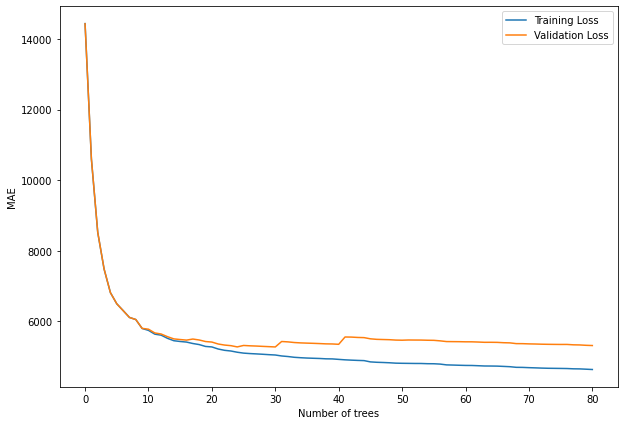

In [32]:
%%time
print(updated_xg_reg)
param_test = {
 'reg_lambda': np.logspace(-2, 1, num = 4)
}
updated_xg_reg = general_gridsearch(xg_reg = updated_xg_reg, param_test = param_test)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=30, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=10.0, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=0)
The best params are: {'learning_rate': 0.5, 'n_estimators': 200} The best mae is: 4873.760045407063
CPU times: user 11min 47s, sys: 8.01 s, total: 11min 55s
Wall time: 1min 32s


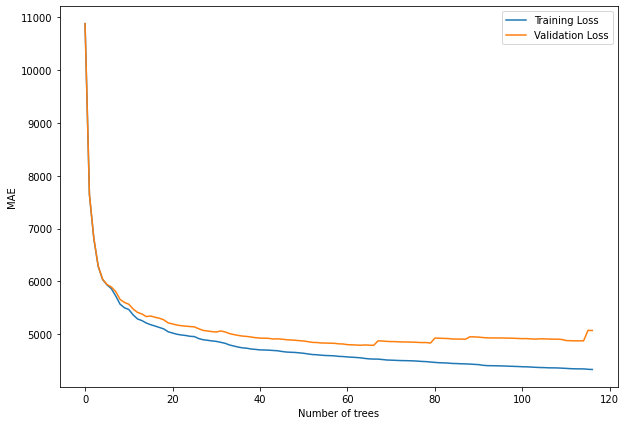

In [33]:
%%time
print(updated_xg_reg)
param_test = {
 'learning_rate': [0.1, 0.3, 0.5], 'n_estimators': [200, 1000, 2000]
}
updated_xg_reg = general_gridsearch(xg_reg = updated_xg_reg, param_test = param_test)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.5, max_delta_step=0, max_depth=3,
             min_child_weight=30, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=10.0, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=0)
The best params are: {'colsample_bytree': 0.1, 'subsample': 0.7} The best mae is: 5408.854362692898
CPU times: user 17min 38s, sys: 31.8 s, total: 18min 10s
Wall time: 2min 42s


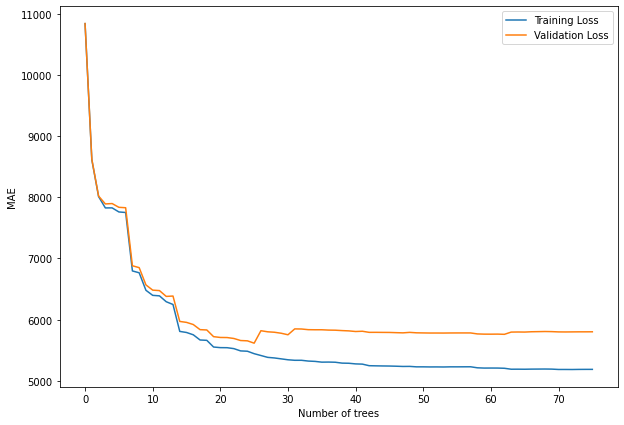

In [34]:
%%time
print(updated_xg_reg)
param_test = {
 'colsample_bytree': [0.1, 0.3, 0.5, 0.7], 'subsample': [0.1, 0.3, 0.5, 0.7]
}
updated_xg_reg = general_gridsearch(xg_reg = updated_xg_reg, param_test = param_test)


Model Report
R^2 of the training set: 0.5183
R^2 of the testing set: 0.5034
MAE of the training set: 5443.2409
MAE of the testing set: 5615.0118
The average R^2 of the 3-fold cross validation = 0.7282, with a std of 0.0026


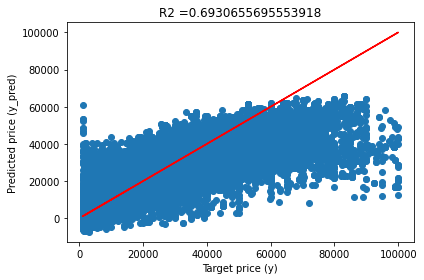

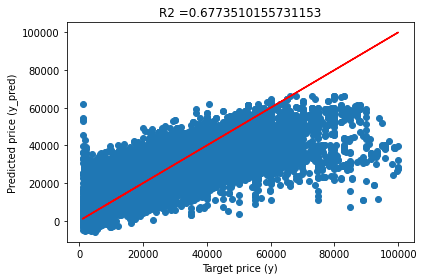

In [55]:
model_fit(updated_xg_reg, label_X_train, y_train, label_X_test, y_test, cv = 3)

## 3. Random Forest


Model Report
R2 of the training set: 0.9843
R2 of the testing set: 0.8567
MAE of the training set: 857.6166
MAE of the testing set: 2649.9168
R2 of the 3-fold cross validation: [0.8812791  0.88103177 0.8802992 ]


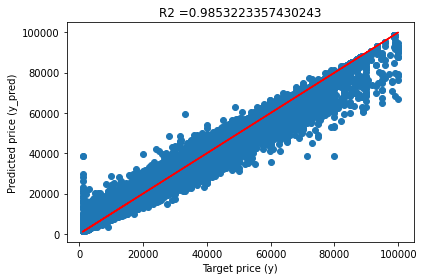

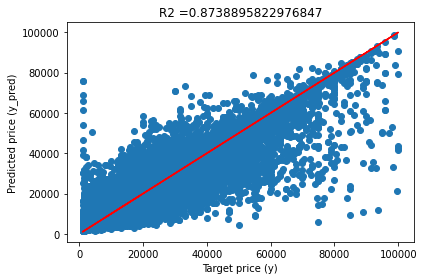

In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
rf_reg = RandomForestRegressor(max_features = 3, random_state=0).fit(label_X_train, y_train)
model_fit(rf_reg, label_X_train, y_train, label_X_test, y_test, cv = 3)

### Try GridSearchCV

In [53]:
from sklearn.model_selection import GridSearchCV # default cv fold = 3
from sklearn.metrics import r2_score, SCORERS, mean_absolute_error
parameters = {'max_features': [3, 4, 5], 'n_estimators': range(5, 21, 5)}
reg = RandomForestRegressor()
reg_grid = GridSearchCV(reg, param_grid = parameters, scoring = 'neg_mean_absolute_error')
reg_grid.fit(label_X_train, y_train)
reg_best = reg_grid.best_estimator_

RandomForestRegressor(max_features=5, n_estimators=20)

Model Report
R^2 of the training set: 0.9817
R^2 of the testing set: 0.8451
MAE of the training set: 891.4574
MAE of the testing set: 2753.9025
The average R^2 of the 3-fold cross validation = 0.8756, with a std of 0.0008


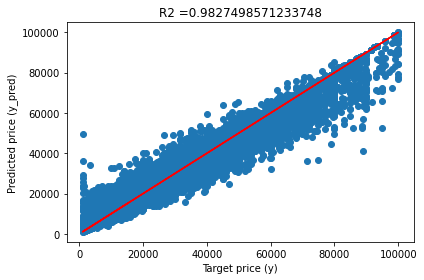

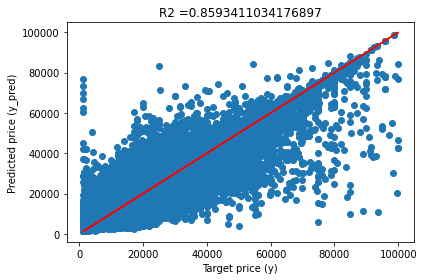

In [54]:
print(reg_best)
model_fit(reg_best, label_X_train, y_train, label_X_test, y_test, cv = 3)